<a href="https://colab.research.google.com/github/MiHess/cxr-bse/blob/master/first_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import glob
import numpy as np
import PIL
import logging
import random
import matplotlib.pyplot as plt
plt.style.use('default')

from PIL import ImageOps
from skimage import exposure
from collections import defaultdict
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [0]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
bse_data_path = "/content/drive/My Drive/dev/bse/data"

jsrt_bse_path = os.path.join(bse_data_path, "jsrt_bse")

jsrt_path = os.path.join(bse_data_path, "jsrt")


In [0]:
def _load_grayscale_image(filepath):
    """
    """
    img_array = np.array(load_img(filepath))[:,:,1]
    
    return img_array.reshape(img_array.shape + (1, ))  
    

def get_train_test_data(X_images_path, y_images_path, test_fraction=0.2):
    """ Loads all images from disk to memory and returns them as numpy array.
    """
    EXPECTED_TOTAL_NUMBER = 247
    
    X_image_filepaths = sorted(glob.glob(os.path.join(X_images_path, "*.png")))
    y_image_filepaths = sorted(glob.glob(os.path.join(y_images_path, "*.png")))
    
    if (len(X_image_filepaths) != EXPECTED_TOTAL_NUMBER) or (len(y_image_filepaths) != EXPECTED_TOTAL_NUMBER):
        raise ValueError(f"expected {EXPECTED_TOTAL_NUMBER} images. "
            f"Found {len(X_image_filepaths)} X and {len(y_image_filepaths)} y images, respectively.")
    else:
        logger.info(f"Found {len(X_image_filepaths)} X images and {len(y_image_filepaths)} y images.")    

    X_images = []
    y_images = []
    for X_image_filepath, y_image_filepath in zip(X_image_filepaths, y_image_filepaths):
        if os.path.basename(X_image_filepath) == os.path.basename(y_image_filepath):
            X_images.append(_load_grayscale_image(X_image_filepath))
            y_images.append(_load_grayscale_image(y_image_filepath))
        else:
            raise ValueError(f"image names do not match: {X_image_filepath} and {y_image_filepath}")
        
    test_idc = random.sample(range(EXPECTED_TOTAL_NUMBER), int(EXPECTED_TOTAL_NUMBER * test_fraction))
    train_idc = [idx for idx in range(EXPECTED_TOTAL_NUMBER) if idx not in test_idc]
    
    return np.array(X_images)[train_idc], np.array(y_images)[train_idc], \
        np.array(X_images)[test_idc], np.array(y_images)[test_idc]
        


In [0]:
X_train, y_train, X_test, y_test = get_train_test_data(jsrt_path, jsrt_bse_path)

In [8]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(49, 512, 512, 1)

In [0]:
seed = 1
batch_size=16


basic_datagen = ImageDataGenerator(
    rescale=1./255)

val_X_generator = basic_datagen.flow(
    X_test,
    batch_size=batch_size,
    seed=seed)

val_y_generator = basic_datagen.flow(
    y_test,
    batch_size=batch_size,
    seed=seed)


augmenting_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_X_generator = augmenting_datagen.flow(
    X_train, 
    batch_size=batch_size, 
    seed=seed)

train_y_generator = augmenting_datagen.flow(
    y_train, 
    batch_size=batch_size, 
    seed=seed)


train_generator = zip(train_X_generator, train_y_generator)
val_generator = zip(val_X_generator, val_y_generator)

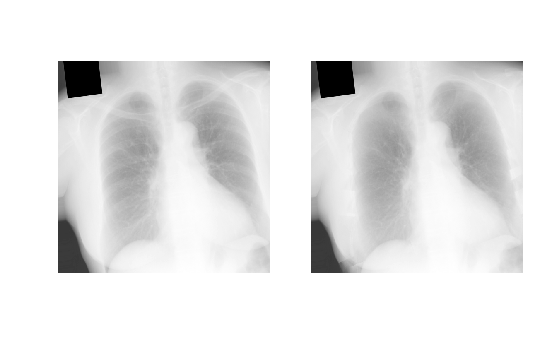

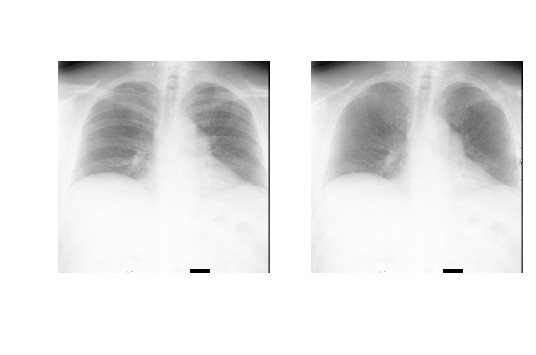

In [95]:
image, image_bse = next(train_generator)

examples = 1
fig, axes = plt.subplots(examples, 2, figsize=(6, 4), sharex=True, sharey=True)
for i in range(examples):
    axes[0].imshow(image[i][:,:,0], cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(image_bse[i][:,:,0], cmap='gray')
    axes[1].axis('off')

image, image_bse = next(val_generator)

examples = 1
fig, axes = plt.subplots(examples, 2, figsize=(6, 4), sharex=True, sharey=True)
for i in range(examples):
    axes[0].imshow(image[i][:,:,0], cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(image_bse[i][:,:,0], cmap='gray')
    axes[1].axis('off')


In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(512, 512, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(input_img, decoded)
# autoencoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [101]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 512, 512, 32)      320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 128, 128)     147584    
__________

In [103]:
epochs=20

autoencoder_train = autoencoder.fit_generator(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=100,
    validation_steps=100,
    epochs=epochs)

Epoch 1/20
100/100 [==============================] - 109s 1s/step - loss: 0.5791 - val_loss: 0.5767
Epoch 2/20
100/100 [==============================] - 104s 1s/step - loss: 0.6024 - val_loss: 0.7178
Epoch 3/20
100/100 [==============================] - 103s 1s/step - loss: 0.5510 - val_loss: 0.4783
Epoch 4/20
100/100 [==============================] - 103s 1s/step - loss: 0.5535 - val_loss: 0.5033
Epoch 5/20
100/100 [==============================] - 104s 1s/step - loss: 0.5128 - val_loss: 0.4770
Epoch 6/20
100/100 [==============================] - 103s 1s/step - loss: 0.5068 - val_loss: 0.4753
Epoch 7/20
100/100 [==============================] - 103s 1s/step - loss: 0.4921 - val_loss: 0.4770
Epoch 8/20
100/100 [==============================] - 105s 1s/step - loss: 0.5040 - val_loss: 0.4762
Epoch 9/20
100/100 [==============================] - 103s 1s/step - loss: 0.4888 - val_loss: 0.4735
Epoch 10/20
100/100 [==============================] - 103s 1s/step - loss: 0.4997 - val_lo

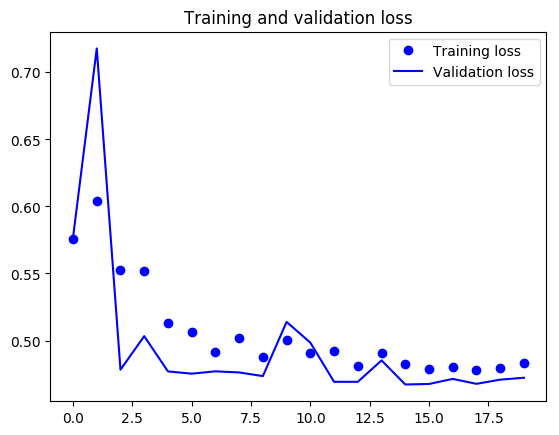

In [104]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()